In [18]:
from pathlib import Path
from xpinn import XPINN
import optax
from type_util import Array
from jax import jacobian, jit, vmap
import jax.numpy as np

# Initializing the XPINN
We begin by reading the points from the relevant file, and setting the activation function for the networks.

In [19]:
file = Path("../data/advection_constraints.json")
file_test = Path("../data/advection_constraints_test.json")
xpinn = XPINN(file, np.tanh)

We plot the points of the domain decomposition. This is beneficial in keeping track of which sub-PINN has which index.

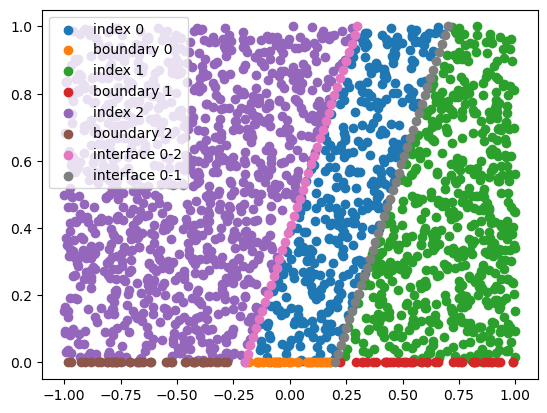

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

# Problem specifications
We consider the 1-D advection equation, defined by
$$
\begin{equation}
    u_t + 0.5 u_x = 0, \quad x \in [-1, 1], t \in [0, 1]
\end{equation}
$$
with the initial conditions
$$
\begin{cases}
    u(x, 0) = 1 & x \in [-0.2, 0.2] \\
    u(x, 0) = 0 & \text{otherwise}
\end{cases}
$$
In the middle PINN, we can set the boundary loss simply as
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) - 1 \rVert_2,
\end{equation}
$$
while for the left and right PINNs we set
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) \rVert_2,
\end{equation}
$$

## Setting the loss function

We create a base function for intializing the boundary loss functions, which is relatively simple in this case.

In [21]:
from typing import Callable
from type_util import Params

LFunc = Callable[[Params, dict[str, Array]], Array]


def create_boundary_loss(index: int, target: float | Array) -> LFunc:
    def boundary_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["boundary"]
        eval = xpinn.PINNs[index].v_model(params, points)
        return np.mean((eval - target) ** 2)

    return boundary_loss

We precompute the relevant derivatives of the interior loss function, in order to speed things up down the line.

In [22]:
# fmt: off
def create_interior_loss(index: int) -> LFunc:
    model = xpinn.PINNs[index].model
    jacob = lambda params: jacobian(lambda x: model(params, x))
    N_dt = lambda params, x: jacob(params)(x)[1]
    N_dx = lambda params, x: jacob(params)(x)[0]
    residual = lambda params, x: (N_dt(params, x) + 0.5 * N_dx(params, x)) ** 2
    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["interior"]
        return np.mean(v_residual(params, points) ** 2)

    return interior_loss
# fmt: on

We now override the boundary and interior loss function of the networks to the updated versions.

In [23]:
p0, p1, p2 = xpinn.PINNs

p0.boundary_loss = create_boundary_loss(0, 1.0)
p1.boundary_loss = create_boundary_loss(1, 0.0)
p2.boundary_loss = create_boundary_loss(2, 0.0)

p0.interior_loss = create_interior_loss(0)
p1.interior_loss = create_interior_loss(1)
p2.interior_loss = create_interior_loss(2)

In the interface losses, we rely on outside communication for updating the values.

In [24]:
def create_inter(i: int, j: int) -> LFunc:

    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((pi.v_model(params, inter_points) - val_j) / 2) ** 2)
        avg_ij = 0

        return res_ij + avg_ij

    # return lambda params, args: 0
    return interface_loss

Again, setting the updated functions.

In [25]:
p0.interface_loss = lambda params, args: create_inter(0, 1)(
    params, args
) + create_inter(0, 2)(params, args)
# p0.interface_loss = lambda params, args: 0
p1.interface_loss = lambda params, args: create_inter(1, 0)(params, args)
p2.interface_loss = lambda params, args: create_inter(2, 0)(params, args)

We can now set the total loss for each network

In [26]:
for p in xpinn.PINNs:
    p.create_loss()

## Setting up the arcitechture of the network

In [27]:
shapes = [[2, 50, 1], [2, 50, 1], [2, 50, 1]]
for pinn, shape in zip(xpinn.PINNs, shapes):
    exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
    optimizer = optax.adam(learning_rate=exponential_decay)

    pinn.init_params(shape, optimizer)

In [28]:
n_iter = 250
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 250: Total loss = 19.82377052307129
10.00% iter = 25 of 250: Total loss = 17.414487838745117
20.00% iter = 50 of 250: Total loss = 12.253724098205566
30.00% iter = 75 of 250: Total loss = 5.279396057128906
40.00% iter = 100 of 250: Total loss = 0.753395140171051
50.00% iter = 125 of 250: Total loss = 0.0016179223312065005
60.00% iter = 150 of 250: Total loss = 0.0037343567237257957
70.00% iter = 175 of 250: Total loss = 2.7702302759280428e-05
80.00% iter = 200 of 250: Total loss = 1.8679298591450788e-05
90.00% iter = 225 of 250: Total loss = 6.280231445998652e-07
100.00% iter = 249 of 250: Total loss = 1.5620122439941042e-07


It's limited how low the loss can be for this problem, while still being physically correct. This stems from the inherent discontinuity from the interfaces, specifically from the averaging of the predicted values. If we in the interface loss function set `avg_ij` to be constant zero, the networks give a lot better results. Here, we want one side of the interface to predict constant $0$, while we want the other side to predict $1$. It can be discussed what the right approach in handling this problem is, given both the simplicity of the problem, and the fact that we have the analytical solution readily available.

Text(0.5, 1.0, 'Loss per Pinn over 250 epochs')

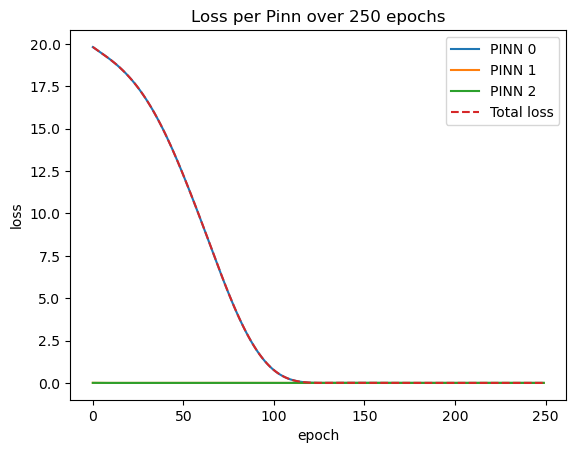

In [29]:
a_losses = np.asarray(losses).T
t_0 = 0
t = np.arange(t_0, n_iter)

for i in range(3):
    plt.plot(t, a_losses[i, t_0:], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

Without looking further into the behaviour at present time, it seems like all of the networks predict values close to zero in the begninning. This leads to it seemingly being correct for PINNs 1 and 2, and seriously wrong for PINN 0. This is expected, as in the begninning epochs the models have not been trained yet. As PINN 0 improves, it starts predicting non-zero values, lowering it's own loss. However, we see that the loss for models 1 and 2 begins increasing, which I assume comes from an increased interface loss.

In [30]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()

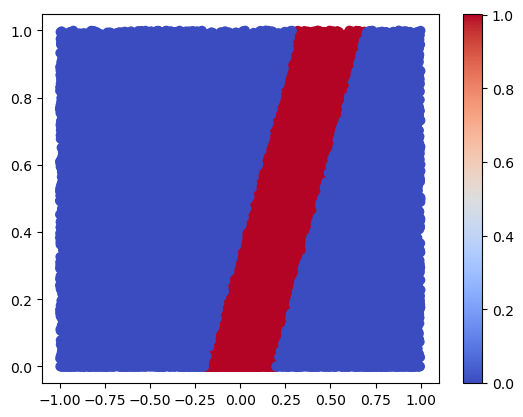

In [31]:
# fig, ax = plt.subplots()

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(min_, max_)
# sc = plt.scatter(
#     points[2][:, 0],
#     points[2][:, 1],
#     c=predictions[2],
#     cmap="viridis_r",
#     label=f"PINN {i}",
# )

plt.colorbar()

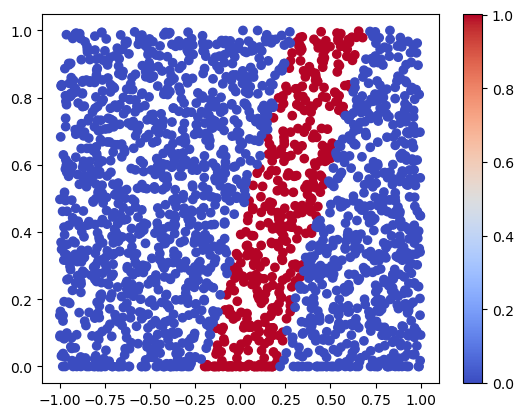

In [32]:
points, predictions = xpinn.predict()
total_pred = np.concatenate(predictions)
min_, max_ = total_pred.min(), total_pred.max()


for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(min_, max_)

plt.colorbar()